### Preprocessing con sostituzione dei valori nan

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

import io
import requests

In [2]:
# URL completi dei file nel repository GitHub
thca_url = '../data/new_tcha_dataset.csv'
lusc_url = '../data/new_lusc_dataset.csv'
skcm_url = '../data/new_skcm_dataset.csv'
coadread_url = '../data/new_coadread_dataset.csv'

In [3]:
def checkNaN(row):
    tmp_idx = -1
    tmp_values = []
    
    for i, value in enumerate(row[1:], start=1):
        
        if pd.isna(value):
            if tmp_idx != -1:
                return pd.Series([None]*len(row), index=row.index)
            else:
                tmp_idx = i
        else:
            tmp_values.append(value)
    
    if tmp_idx != -1:
        row.iloc[tmp_idx] = np.mean(tmp_values)
                
    return row

In [4]:
def processing_ds(ds_url):
    #s = requests.get(ds_url).content
    #ds = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t')
    ds = pd.read_csv(ds_url)
    
    #ds = ds.drop(columns='Hugo_Symbol', axis=1)

    #ds = ds[:10000]  # per fare prove 
    
    ds = ds.apply(checkNaN, axis=1) # Applica la funzione a ogni *riga* del df
    ds.dropna(inplace=True)
    
    file_name = ds_url.split('/')[-1].split('.')[0]       # nome del file dall'URL
    ds.to_csv(f'../data/clean_{file_name}.csv', index=False)

    # Verifica se il df contiene valori NaN lungo le righe
    if ds.isnull().any(axis=1).any():
        print("Il dataframe contiene valori NaN lungo le righe.")

    # Elimina geni che hnno lo stesso ID
    if ds.duplicated(subset=['Entrez_Gene_Id']).sum() > 0:
        ds = ds.drop_duplicates(subset=['Entrez_Gene_Id'])

    ds.reset_index(drop=True, inplace=True)

    return ds

In [5]:
ds_thca = processing_ds(thca_url)

In [6]:
ds_lusc = processing_ds(lusc_url)

In [7]:
ds_skcm = processing_ds(skcm_url)

In [8]:
ds_coadread = processing_ds(coadread_url)

### Correlation matrix per eliminaregeni con correlazione superiore a 0.9


In [9]:
def corr_matrix(ds):
    ds.set_index('Entrez_Gene_Id', inplace=True)
    
    # Calcola la matrice di correlazione tra i geni
    corr_matrix = ds.T.corr()

    return corr_matrix

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_genes(ds, threshold, count = 10):
    cm = corr_matrix(ds)  

    # Creiamo una copia della matrice di correlazione per lavorare sui valori
    significant_corr = cm.copy()

    # Imposta la diagonale su un valore non significativo per ignorarla
    np.fill_diagonal(significant_corr.values, 0)

    # Convertiamo la matrice in un DataFrame lungo (melted)
    melted_correlation = significant_corr.reset_index().melt(id_vars='Entrez_Gene_Id')

    # Filtriamo solo le coppie con un valore di correlazione maggiore della soglia
    filtered_pairs = melted_correlation[(melted_correlation['value'] > threshold) | (melted_correlation['value'] < - threshold)]

    # Rinominiamo le colonne per chiarezza
    filtered_pairs.columns = ['Gene1', 'Gene2', 'Correlation']

    # Visualizziamo i risultati
    #print(filtered_pairs)

    # Combinare Gene1 e Gene2 in un'unica serie e contare le frequenze
    all_genes = pd.concat([filtered_pairs['Gene1'], filtered_pairs['Gene2']])
    gene_counts = all_genes.value_counts()

    # Visualizziamo i risultati
    #print(gene_counts)

    # Creiamo il grafico delle frequenze dei geni
    plt.figure(figsize=(10, 6))
    gene_counts.plot(kind='bar')
    plt.xlabel('Genes')
    plt.ylabel('Frequency')
    plt.title('Distribution of Gene Frequencies in Filtered Pairs')
    plt.xticks(rotation=90)
    plt.show()

    # Prendere tutti i geni che hanno un count maggiore di COUNT e metterli in una lista
    genes_above_threshold = gene_counts[gene_counts > count].index.tolist()

    # Visualizziamo i geni sopra la soglia
    #print("Geni con count maggiore di 10:", genes_above_threshold)

    ds = delete_rows(ds, genes_above_threshold)  # Assuming delete_rows is defined elsewhere
    
    return ds


In [11]:
def delete_rows(df, valori_da_eliminare):
    print("Numero geni da togliere:" , len(valori_da_eliminare))
    print("Lunghezza database prima di togliere geni:" , len(df))    
    df.reset_index(inplace=True)

    #x = ~df['Entrez_Gene_Id'].isin(valori_da_eliminare)
    #print(len(x))
    #print(x)
    
    # Filtrare il DataFrame per eliminare le righe con i valori specificati in 'entrez'
    df = df[~df['Entrez_Gene_Id'].isin(valori_da_eliminare)]

    print("Lunghezza database dopo aver tolto i geni:" , len(df)) 
    
    return df



In [12]:
dslusc_genesremoved = remove_genes(ds_lusc, 0.9)

# Salva il DataFrame come file CSV
dslusc_genesremoved.to_csv('../data/dslusc_genesremoved.csv', index=False)

In [ ]:
dsthca_genesremoved = remove_genes(ds_thca, 0.9)

# Salva il DataFrame come file CSV
dsthca_genesremoved.to_csv('../data/dsthca_genesremoved.csv', index=False)

In [ ]:
dsskcm_genesremoved = remove_genes(ds_skcm, 0.9)

# Salva il DataFrame come file CSV
dsskcm_genesremoved.to_csv('../data/dsskcm_genesremoved.csv', index=False)

In [ ]:
dsco_genesremoved = remove_genes(ds_coadread, 0.9)

# Salva il DataFrame come file CSV
dsco_genesremoved.to_csv('../data/dsco_genesremoved.csv', index=False)

In [ ]:
#ds_lusc = delete_rows(ds_lusc, valori_scelti)

### Outlier detection

In [ ]:
df = ds_lusc
genes = df['Entrez_Gene_Id']
df = df.drop(columns=['Entrez_Gene_Id'])

In [ ]:
df.head()

,TCGA-21-5787-01,TCGA-34-2596-01,TCGA-34-5231-01,TCGA-37-4141-01,TCGA-39-5031-01,TCGA-43-A475-01,TCGA-63-5128-01,TCGA-68-A59J-01,TCGA-77-A5G3-01,TCGA-90-A4ED-01,TCGA-98-A53B-01
0,-4.8669,-4.8669,-1.4109,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669
1,-2.2769,-1.8432,0.9940,-0.0427,-0.6309,0.1270,0.9573,-0.0815,0.9524,0.8139,1.1773
2,-3.7670,-0.8027,0.6230,-0.1083,-0.0303,1.5171,0.4976,0.4431,0.2772,1.2035,1.6293
3,-0.3575,-0.0693,-0.1670,1.5169,0.6871,-0.7620,-0.2407,0.0809,-0.1153,-0.3154,-0.6674
4,2.1348,-0.4077,-0.0961,1.0508,-0.2250,-0.3290,-1.5327,-0.6485,0.1850,-1.0397,0.4995


#### LocalOutlierFactor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
outliers_lof = lof.fit_predict(df) 

print(f"Sono stati trovati {len(outliers_lof[outliers_lof==-1])} outliers")
df_filtered=df[outliers_lof==1]

#print(df_filtered)

Sono stati trovati 493 outliers


In [ ]:
#pip install --upgrade scikit-learn
#pip install --upgrade threadpoolctl


In [ ]:
len(outliers_lof)

9949

In [ ]:
len(df)

9949

In [ ]:
len(df_filtered)

9456

#### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators = 100, max_samples='auto', random_state=42)
iso_forest.fit(df)
outliers_isoF = iso_forest.predict(df)

#print(outliers)
print(f"Sono stati trovati {len(outliers_isoF[outliers_isoF==-1])} outliers")
df_filtered=df[outliers_isoF==1]

#print(df_filtered)

Sono stati trovati 364 outliers


In [ ]:
#print(outliers_lof)
#print(outliers_isoF)

In [ ]:
#common_elements = [(i, outliers_lof[i]) for i in range (len(outliers_lof)) if outliers_lof[i] == outliers_isoF[i] & outliers_lof[i] == -1]

In [ ]:
common = []
for i in range(len(outliers_lof)):
    if outliers_lof[i] == outliers_isoF[i] :
        if outliers_lof[i] == -1 :
            common.append(True)

print(len(common))
#print(len(common_elements))

136


#### Angle-based outliers

ABOD (Angle-Based Outlier Detection) si basa sul principio che i punti che sono circondati da molti punti vicini formano angoli più ampi rispetto ai punti isolati (outliers). 

https://blog.paperspace.com/outlier-detection-with-abod/

parametri default:
class pyod.models.abod.ABOD(contamination=0.1, n_neighbors=10, method='fast') <br>
0.1 significa che ci aspettiamo il 10% di outliers


In [ ]:
#pip install pyod

In [ ]:
# Importare le librerie necessarie per il rilevamento degli outliers
from pyod.models.abod import ABOD
import pandas as pd

# Funzione per il rilevamento degli outliers usando ABOD
def detect_outliers_abod(data):
    clf = ABOD()  # parametri default
    clf.fit(data)
    
    # Ottenere i punteggi di outlier e le etichette (0: inlier, 1: outlier)
    outlier_scores = clf.decision_function(data)
    outlier_labels = clf.predict(data)

    # Cambiare le etichette: 1 per inliers, -1 per outliers
    outlier_labels = np.array([1 if label == 0 else -1 for label in outlier_labels])
    
    #print(outlier_labels, "\n------\n", outlier_scores)
    return outlier_scores, outlier_labels

# Applicare il rilevamento degli outliers
outlier_scores, outliers_abod = detect_outliers_abod(df)
print(f"Sono stati trovati {len(outliers_abod[outliers_abod==-1])} outliers")
df_filtered = df[outliers_abod==1]

# Aggiungere le etichette degli outliers al dataframe originale ###
#df['outlier_label'] = outlier_labels

# Salvare i risultati in un nuovo file CSV
#output_file = 'outlier_detected_data.csv'
#data.to_csv(output_file, index=False)

#df_filtered.head()


ModuleNotFoundError: No module named 'pyod'

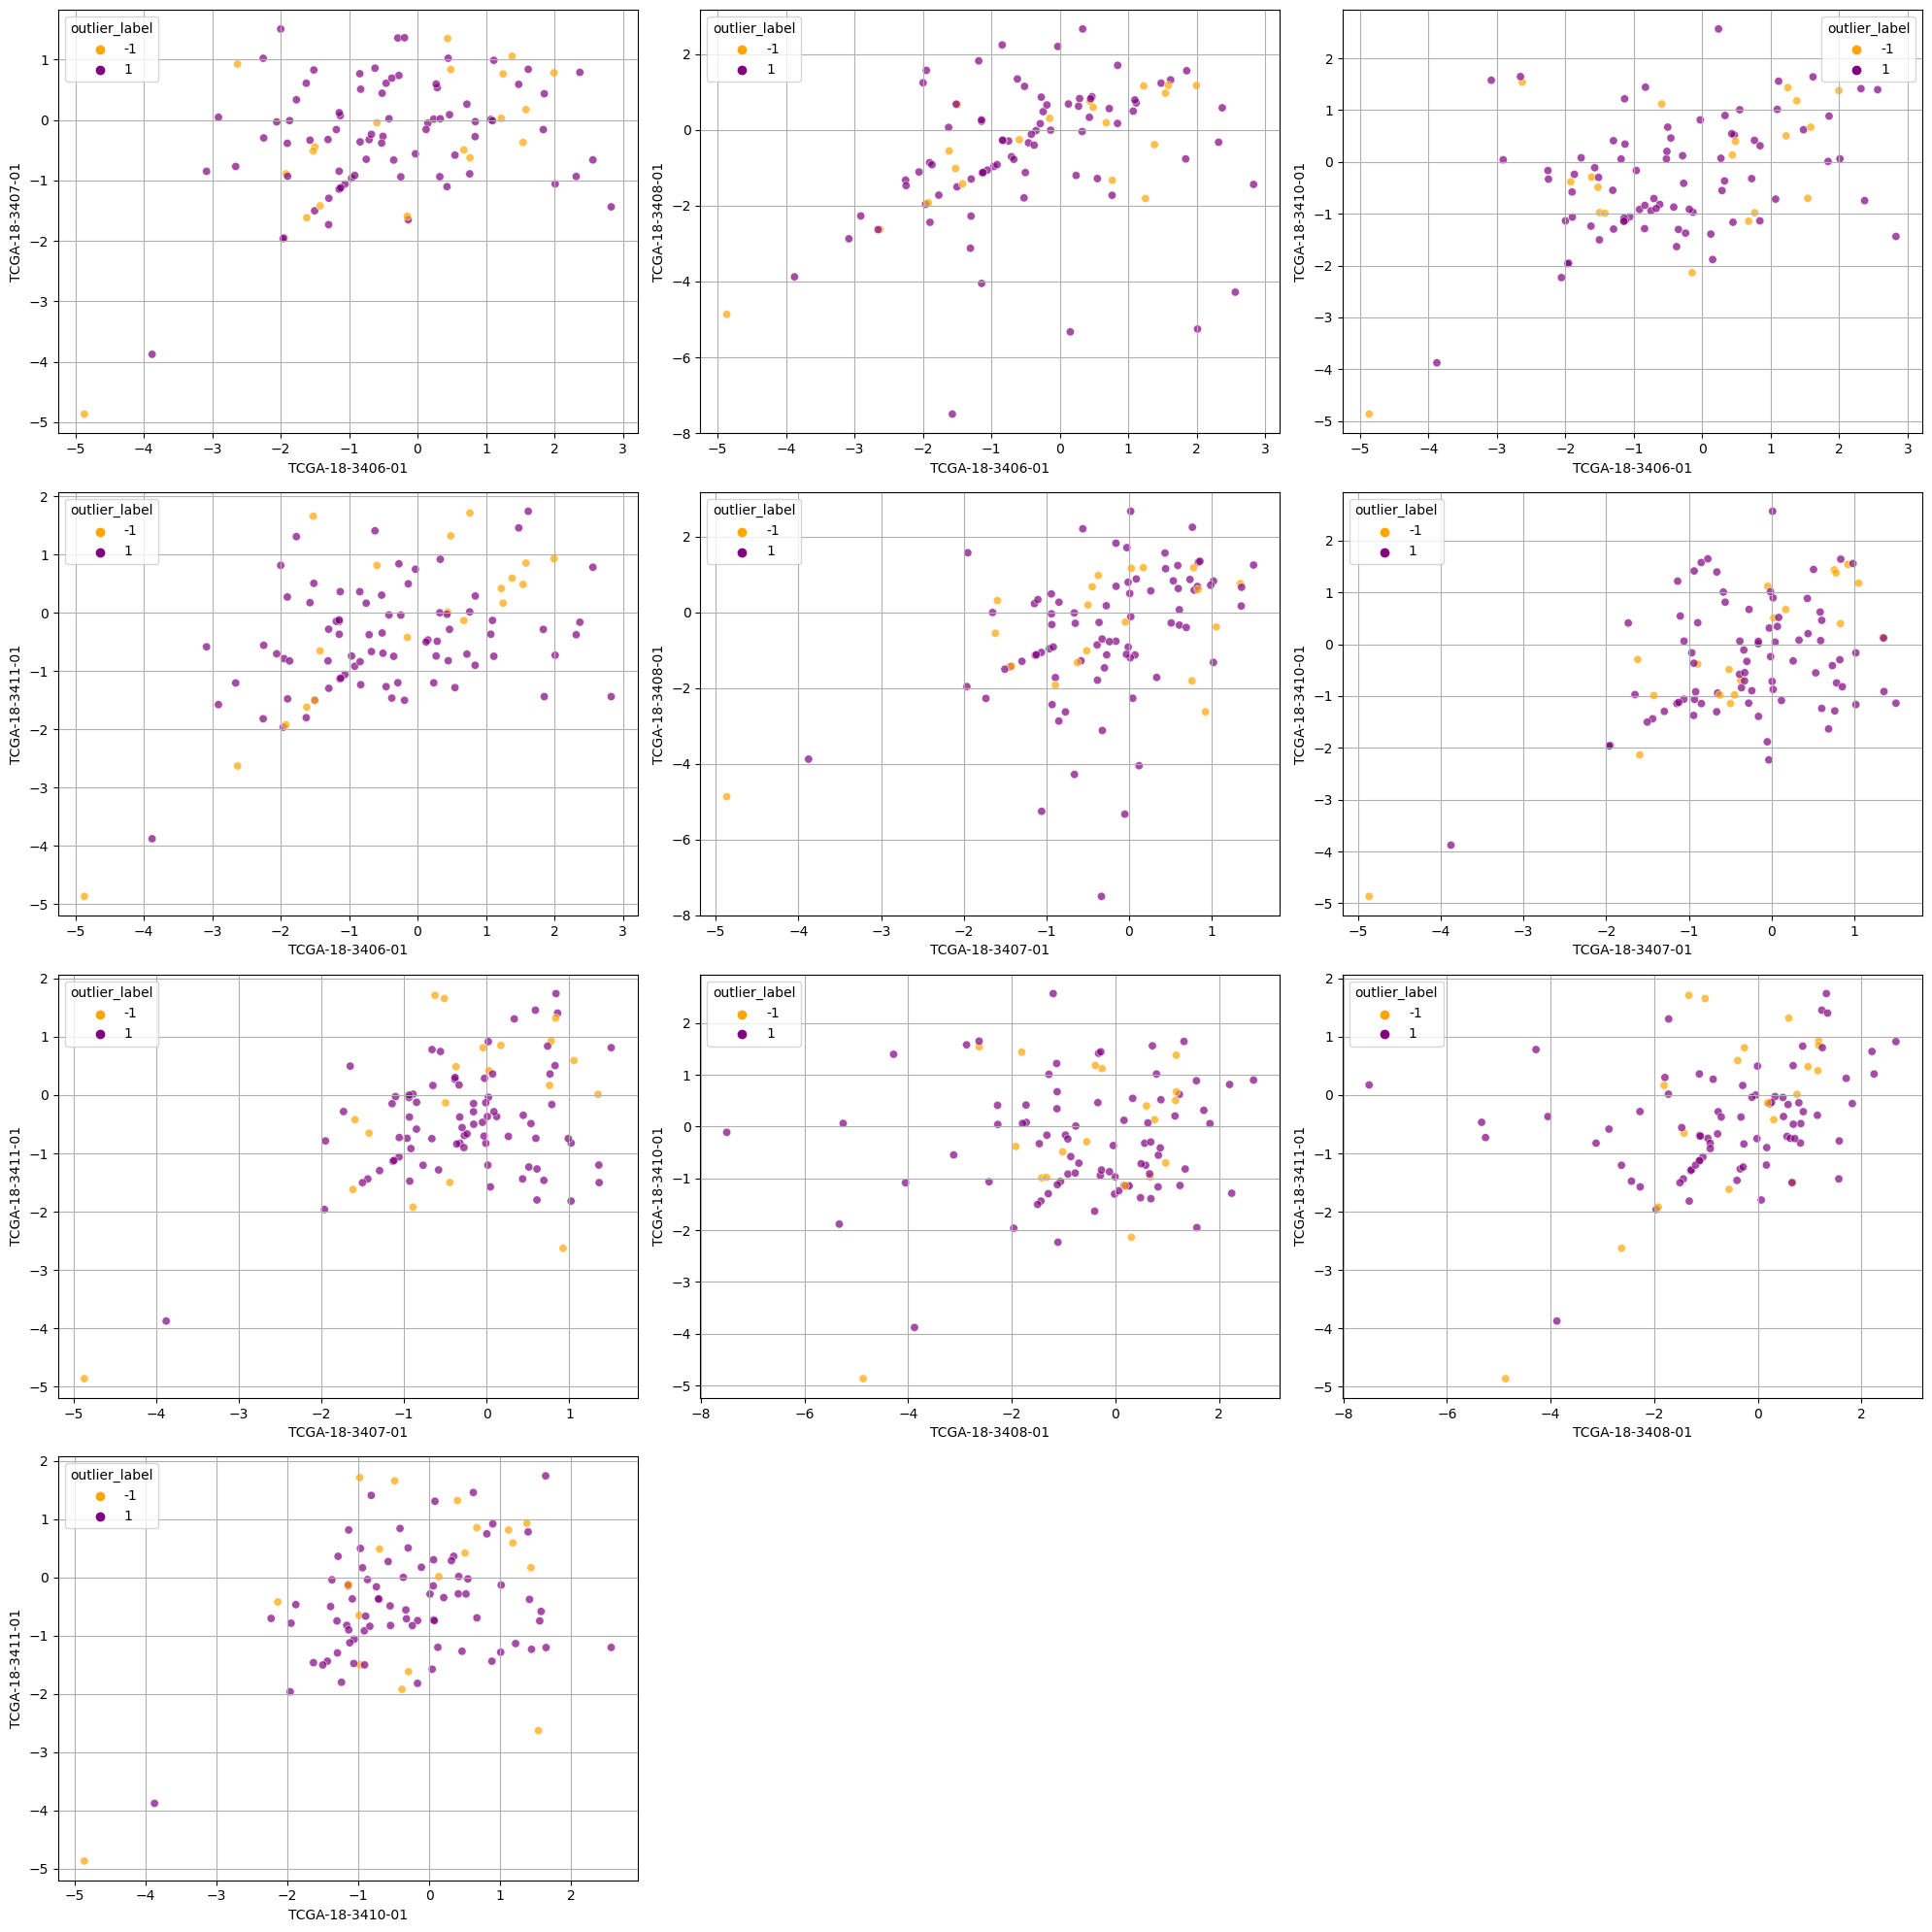

In [ ]:
# Plotta i punti e i centroidi
n = len(df.columns)
n=5
num_plots = (n - 1) * n // 2

fig, axs = plt.subplots((num_plots + 2) // 3, 3, figsize=(20, 20))
axs = axs.flatten()

plot_num = 0
for i in range(n - 1):
    for j in range(i + 1, n):
        x = df.iloc[:, i]
        y = df.iloc[:, j]
        sns.scatterplot(x=x, y=y, hue='outlier_label', data=df, ax=axs[plot_num], alpha=0.7, palette={1: "purple", -1: "orange"})
        axs[plot_num].set_xlabel(df.columns[i])
        axs[plot_num].set_ylabel(df.columns[j])
        axs[plot_num].grid(True)
        plot_num += 1

# Rimuovere gli assi vuoti
for ax in axs[plot_num:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

#### KNN

In [ ]:
from pyod.models.knn import KNN

In [ ]:
knn = KNN(method = 'mean', n_neighbors=20, metric='euclidean')
knn.fit(df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='mean',
  metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=20, p=2,
  radius=1.0)

In [ ]:
predicted = pd.Series(knn.predict(df), index=df.index)
print('# of outliers ', predicted.sum())

# of outliers  6


In [ ]:
# Trasforma la serie in un array NumPy
#outliers_knn = predicted.values

# Applica la trasformazione
outliers_knn = predicted.replace({0: 'OK', 1: 'OUTLIER'}).values
#print(outliers_knn)

outliers_knn = np.where(outliers_knn == 'OUTLIER', -1, 1)

# Stampa il risultato
print("LEN prima di filtrare: ", len(outliers_knn), "\n")
#print(outliers_knn)

print(f"Sono stati trovati {len(outliers_knn[outliers_knn==-1])} outliers")
df_filtered = df[outliers_knn==1]

print(len(df))
print(len(df_filtered))

LEN prima di filtrare:  97 

Sono stati trovati 6 outliers
97
91


TODO:  
- tuning di parametri: n_neighbors, contamination (adesso settato di default), estimators in IF (consigliato 100 dal prof
- in KNN valutare le metriche di distanza 
- per ogni metodo è stata mantenuta una maschera: alla fine valutare quali outlier sono comuni 

### feature selection